### Visualization for Förskoleappen

This program visualize the actual attendance vs the planned attendance on several preschools (anonymized) in the Stockholm area. 

In [108]:
import pandas as pd
import numpy as np
import scipy as scipy
import datetime as dt
from collections import Counter
import matplotlib.pyplot as plt
import pyodbc

In [67]:
def read_local_data(path='./old_data/'):
    '''
    This function reads in all attendance excel-files stored in a folder and returns a dataframe.
    Parameters:
        path : str
            The file path to where the xls-files can be found
            Example path = './my_files/'
        
    Returns:
        df : dataframe
        A dataframe with attendance data from all the files in the folder.
    '''
    
    # Only search for .xls files in folder
    xls_path = path + '*.xls'
    
    files = glob.glob(xls_path)
    
    # The column names need to be adjusted to these to prepare the dataframe for export
    
    colnames = ['SchoolId', 'WorkGroupId', 'Date', 'ChildId', 'ChildFirstName', 'Schedule-in',
               'Schedule-out', 'Check-in', 'Check-out', 'FreeTime', 'Absent']
    frames = []

    for filename in files:
        tdf = pd.read_excel(filename, index_col=None, header=2, names=colnames)
        frames.append(tdf)
    
    df = pd.concat(frames, axis=0, ignore_index=True)
    
    return df

In [ ]:
def read_from_db(school, date):
    '''
    This function returns a dataframe from a SQL query
    Parameters:
        school : str
            The school of interest.
        date : str
            The from date.
    
    Returns:
        df : dataframe
    '''
    
    # Insert parameters for SQL connection
    sql_conn = pyodbc.connect('''DRIVER={ODBC Driver 17 for SQL Server}; SERVER=??????; 
    DATABASE=????????;   Trusted_Connection=yes''')
    
    # Choose the correct columns
    query = '''SELECT 'SchoolId', 'WorkGroupId', 'Date', 'ChildId', 'ChildFirstName', 'Schedule-in',
               'Schedule-out', 'Check-in', 'Check-out', 'FreeTime', 'Absent'
               FROM table_with_attendance_data
               WHERE SchoolId= {0} AND Date >= {1}
    '''.format(school, date)
    
    df = pandas.read_sql(sql,cnxn)
    
    return df

In [68]:
read_local_data()

,SchoolId,WorkGroupId,Date,ChildId,ChildFirstName,Schedule-in,Schedule-out,Check-in,Check-out,FreeTime,Absent
0,163,417,2019-08-01,72947,2 Sofie,-,-,-,-,0,0
1,163,417,2019-08-01,72948,3 Heléne,-,-,-,-,0,0
2,163,417,2019-08-01,72949,4 Marie E,-,-,-,-,0,0
3,163,417,2019-08-01,66319,Alexander,-,-,-,-,1,0
4,163,417,2019-08-01,54226,Alice,-,-,08:59:00,-,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10823,159,402,2019-10-18,70549,Nora,07:45:00,15:00:00,07:51:00,15:09:00,0,0
10824,159,402,2019-10-18,65811,Svante,-,-,07:43:00,15:30:00,0,0
10825,159,402,2019-10-18,61172,Tim,07:00:00,16:00:00,07:51:00,15:57:00,0,0
10826,159,402,2019-10-18,70553,Tyra,-,-,-,-,0,0


In [101]:
def prep_and_visualize(local_read = True, days='All', image_filename='output_image'):
    '''
    This function prepares the data and returns a visualization as a png-file.
    Parameters:
        local_read : bool
            If True it will read from the locally stored files, otherwise it will read from the SQL-database
        days : str
            The day or days of the week of interest. You can choose 'All' or select just one day like 'Monday'.
    '''
    
    if local_read:
        df = read_local_data()
    else:
        df = read_from_db()
    
    df['Weekday'] = df['Date'].dt.day_name()
    
    if days == 'All':
        doi = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    else:
        doi = [days]
    
    # Filter dataframe and format dates correctly

    fdf = df[(df['Check-in'] != '-') & (df['FreeTime'] == 0) & (df['Schedule-in'] != '-') 
             & (df['Schedule-out'] != '-') & (df['Check-out'] != '-') & (df['Weekday'].isin(doi)) 
             ].copy()

    fdf['Check-in'] = pd.to_datetime(fdf['Date'].astype(str) + ' ' +fdf['Check-in'].astype(str))
    fdf['Check-out'] = pd.to_datetime(fdf['Date'].astype(str) + ' ' +fdf['Check-out'].astype(str))
    fdf['Schedule-in'] = pd.to_datetime(fdf['Date'].astype(str) + ' ' +fdf['Schedule-in'].astype(str))
    fdf['Schedule-out'] = pd.to_datetime(fdf['Date'].astype(str) + ' ' +fdf['Schedule-out'].astype(str))

    fdf['actual'] = fdf['Check-out'] - fdf['Check-in']
    fdf['planned'] = fdf['Schedule-out'] - fdf['Schedule-in']

    # Calculate the total checked in hours and the total planned hours
    
    tphours = []
    tchours = []
    for index, row in fdf.iterrows():
        # Create a list of the start and end hour
        chours = pd.PeriodIndex(data = [row['Check-in'], row['Check-out']], freq='H').hour.tolist()
        chours = list(range(chours[0], chours[1]+1)) # add all the hours between the periods
        tchours.append(chours)
        # Same as above but for planned
        phours = pd.PeriodIndex(data = [row['Schedule-in'], row['Schedule-out']], freq='H').hour.tolist()
        phours = list(range(phours[0], phours[1]+1))
        tphours.append(phours)
    
    flat_list = [item for sublist in tchours for item in sublist]
        
    checkcount=sorted(Counter(flat_list).items())

    flat_list_2 = [item for sublist in tphours for item in sublist]

    plancount=sorted(Counter(flat_list_2).items())

    act_df = fdf['actual'].mean()
    pla_df = fdf['planned'].mean()

    act = fdf.groupby(['Weekday'])[['actual']].sum()
    pla = fdf.groupby(['Weekday'])[['planned']].sum()

    fig = plt.figure(figsize=(20,10))
    ax = fig.gca()

    ah, noc = zip(*checkcount) # unpack a list of pairs into two tuples
    ph, nop = zip(*plancount)

    width = np.min(np.diff(ah))/3

    doias = ' '.join(doi)

    plt.bar(ah-width, noc, width = 0.3)
    plt.bar(ph, nop, width = 0.3)
    ax.set_title('Actual hours (blue) vs planned hours (orange) on {}s '.format(doias))
    plt.xlabel('Time of day')
    plt.ylabel('Cumulated hours')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(image_filename, dpi=125, bbox_inches='tight')

    plt.show()

    return
    

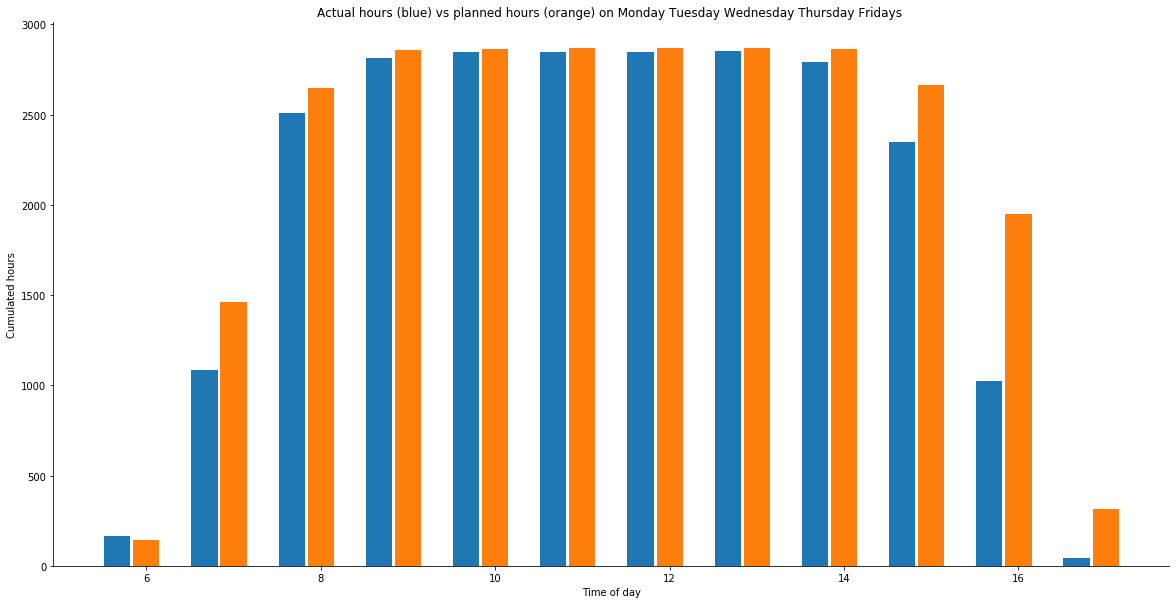

In [102]:
prep_and_visualize(local_read = True, days='All')